In [1]:
%matplotlib inline
import math, time, random, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import catboost
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

In [2]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')
gender_submission = pd.read_csv('../input/titanic/gender_submission.csv') # example of what a submission should look like

In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


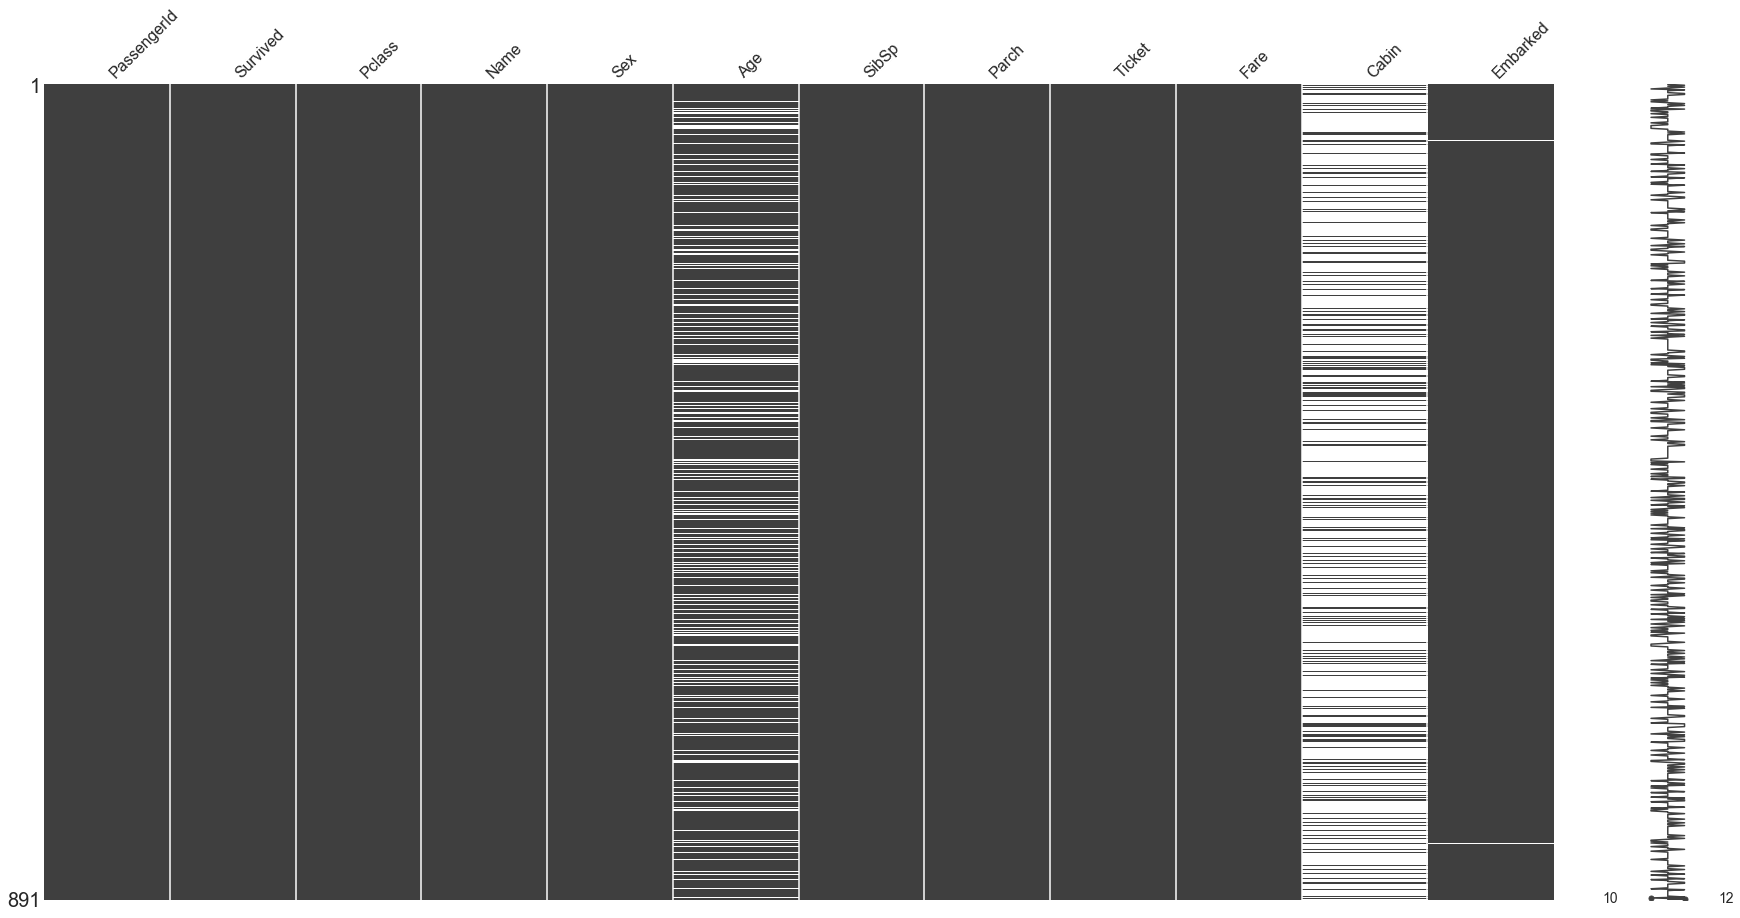

In [4]:
missingno.matrix(train, figsize=(30, 15))

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
train.Survived.unique()

array([0, 1], dtype=int64)

0    549
1    342
Name: Survived, dtype: int64


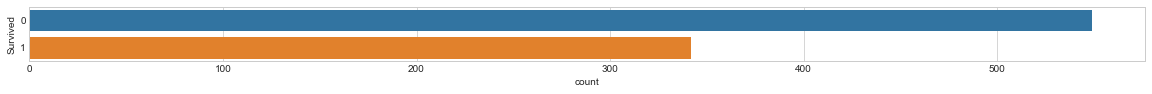

In [8]:
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print(train.Survived.value_counts())

In [9]:
df_bin = pd.DataFrame()
df_con = pd.DataFrame()
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

0

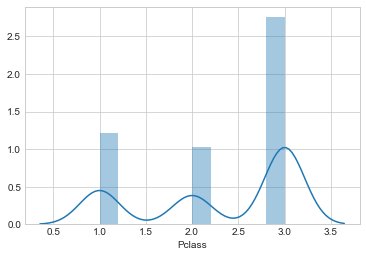

In [10]:
sns.distplot(train.Pclass)
train.Pclass.isnull().sum()

In [11]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [12]:
train.Name.value_counts()

Guggenheim, Mr. Benjamin                                             1
Harper, Miss. Annie Jessie "Nina"                                    1
Brocklebank, Mr. William Alfred                                      1
Olsen, Mr. Karl Siegwart Andreas                                     1
Sage, Miss. Dorothy Edith "Dolly"                                    1
Wiklund, Mr. Jakob Alfred                                            1
Strom, Miss. Telma Matilda                                           1
Heikkinen, Miss. Laina                                               1
Duff Gordon, Lady. (Lucille Christiana Sutherland) ("Mrs Morgan")    1
Zimmerman, Mr. Leo                                                   1
Olsen, Mr. Henry Margido                                             1
Klasen, Mr. Klas Albin                                               1
Fox, Mr. Stanley Hubert                                              1
Cook, Mr. Jacob                                                      1
Moussa

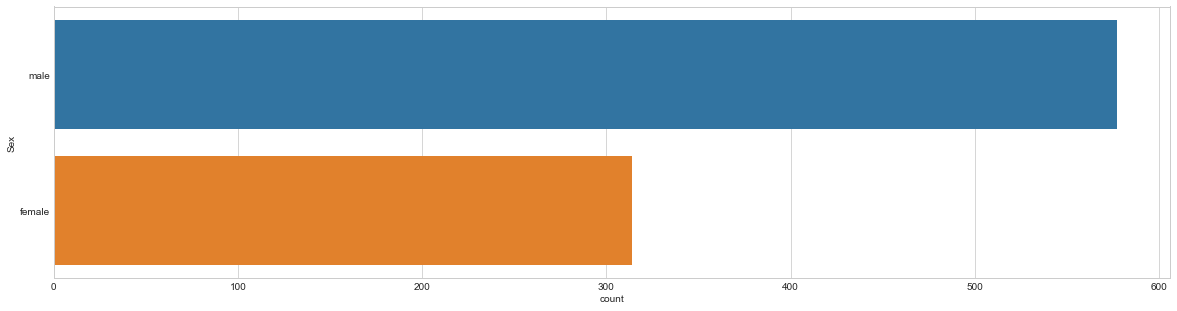

In [13]:
plt.figure(figsize=(20, 5))
sns.countplot(y="Sex", data=train);

In [14]:
train.Sex.isnull().sum()

0

In [15]:
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0) # change sex to 0 for male and 1 for female

df_con['Sex'] = train['Sex']

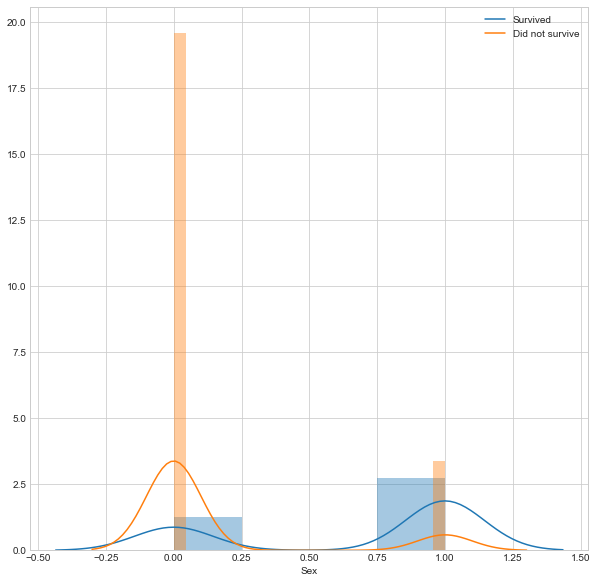

In [16]:
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'});
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survive'});

In [17]:
train.Age.isnull().sum()

177

In [18]:
df_bin['Age'] = pd.cut(train['Age'], 10)
df_con['Age'] = train['Age']
df_con = df_con.dropna(subset=['Age'])
df_bin = df_bin.dropna(subset=['Age'])

In [19]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

In [20]:
train.SibSp.isnull().sum()

0

In [21]:
# What values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [22]:
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

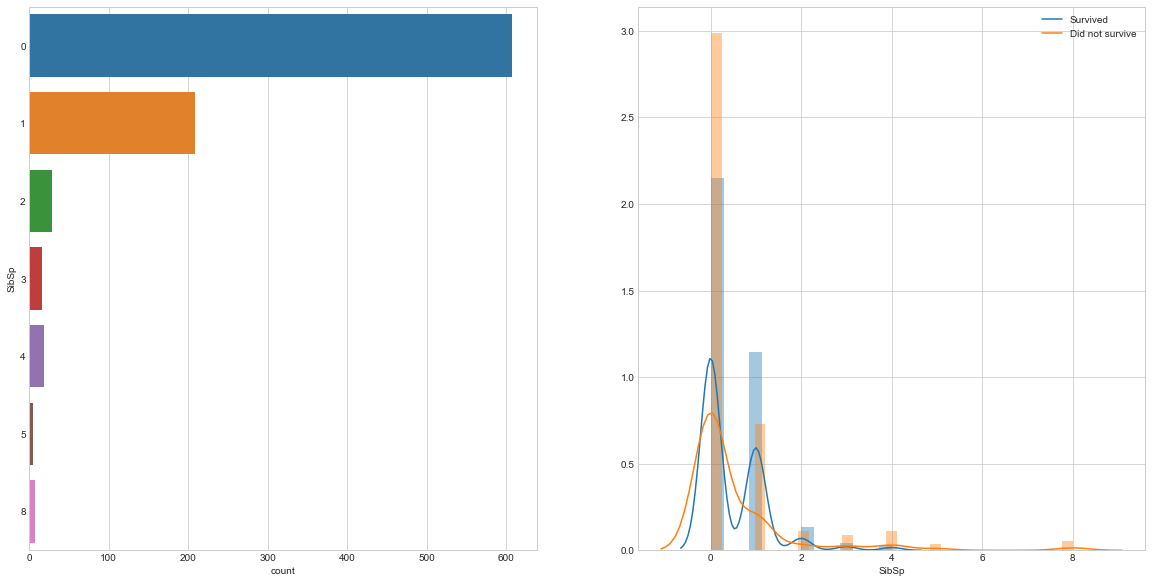

In [23]:
plot_count_dist(train, 
                bin_df=df_bin, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

In [24]:
train.Ticket.isnull().sum()

0

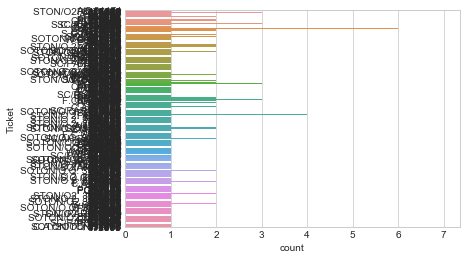

In [25]:
sns.countplot(y="Ticket", data=train);

In [26]:
train.Ticket.value_counts()

1601                  7
347082                7
CA. 2343              7
3101295               6
CA 2144               6
347088                6
382652                5
S.O.C. 14879          5
PC 17757              4
17421                 4
LINE                  4
347077                4
4133                  4
2666                  4
113781                4
19950                 4
349909                4
113760                4
W./C. 6608            4
347742                3
363291                3
345773                3
230080                3
248727                3
PC 17760              3
SC/Paris 2123         3
35273                 3
13502                 3
110413                3
PC 17582              3
                     ..
349249                1
STON/O 2. 3101275     1
113501                1
113028                1
345777                1
349245                1
SC/AH Basle 541       1
341826                1
13568                 1
330923                1
A/5 3594        

In [27]:
print("There are {} unique Ticket values.".format(len(train.Ticket.unique())))

There are 681 unique Ticket values.


In [28]:
df_con['Fare'] = train['Fare'] 
df_bin['Fare'] = pd.cut(train['Fare'], bins=5) # discretised

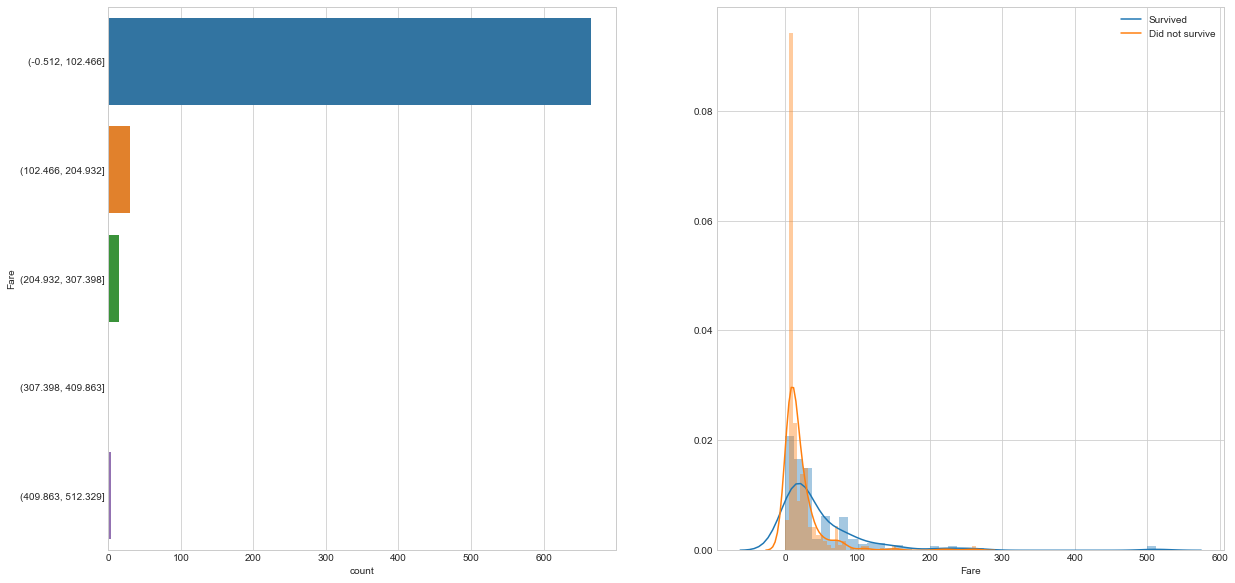

In [29]:
plot_count_dist(data=train,
                bin_df=df_bin,
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20,10), 
                use_bin_df=True)

In [30]:
train.Cabin.isnull().sum()

687

In [31]:
train.Cabin.value_counts()

G6                 4
C23 C25 C27        4
B96 B98            4
D                  3
F2                 3
C22 C26            3
E101               3
F33                3
B77                2
D36                2
E44                2
C52                2
C92                2
D20                2
E8                 2
C93                2
D35                2
C83                2
E67                2
B28                2
B57 B59 B63 B66    2
D33                2
C125               2
E33                2
C2                 2
B5                 2
B22                2
D17                2
F4                 2
E24                2
                  ..
E34                1
A24                1
C82                1
A32                1
E49                1
C148               1
C91                1
C30                1
E50                1
E10                1
C54                1
C103               1
E63                1
B101               1
B50                1
E17                1
B4           

In [32]:
train.Embarked.isnull().sum()

2

In [33]:
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

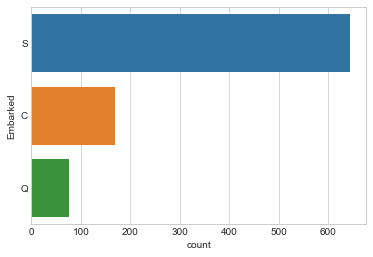

In [34]:
sns.countplot(y='Embarked', data=train);

In [35]:
df_bin['Embarked'] = train['Embarked']
df_con['Embarked'] = train['Embarked']

In [36]:
df_con = df_con.dropna(subset=['Embarked'])
df_bin = df_bin.dropna(subset=['Embarked'])

In [37]:
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked
0,0,3,0,"(16.336, 24.294]",1,"(-0.512, 102.466]",S
1,1,1,1,"(32.252, 40.21]",1,"(-0.512, 102.466]",C
2,1,3,1,"(24.294, 32.252]",0,"(-0.512, 102.466]",S
3,1,1,1,"(32.252, 40.21]",1,"(-0.512, 102.466]",S
4,0,3,0,"(32.252, 40.21]",0,"(-0.512, 102.466]",S


In [38]:
one_hot_cols = df_bin.columns.tolist()
one_hot_cols.remove('Survived')
df_bin_enc = pd.get_dummies(df_bin, columns=one_hot_cols)

df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,"Age_(0.34, 8.378]","Age_(8.378, 16.336]","Age_(16.336, 24.294]","Age_(24.294, 32.252]",...,SibSp_4,SibSp_5,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [39]:
df_embarked_one_hot = pd.get_dummies(df_con['Embarked'], 
                                     prefix='embarked')

df_sex_one_hot = pd.get_dummies(df_con['Sex'], 
                                prefix='sex')

df_plcass_one_hot = pd.get_dummies(df_con['Pclass'], 
                                   prefix='pclass')

In [40]:
df_con_enc = pd.concat([df_con, 
                        df_embarked_one_hot, 
                        df_sex_one_hot, 
                        df_plcass_one_hot], axis=1)

df_con_enc = df_con_enc.drop(['Pclass', 'Sex', 'Embarked'], axis=1)

In [41]:
selected_df = df_con_enc

In [42]:
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [43]:
def fit_ml_algo(algo, X_train, y_train, cv):
    

    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)

    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [44]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 80.2
Accuracy CV 10-Fold: 79.35
Running Time: 0:00:25.718145


In [45]:
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 80.9
Accuracy CV 10-Fold: 70.51
Running Time: 0:00:00.833949


In [46]:
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 77.53
Accuracy CV 10-Fold: 77.11
Running Time: 0:00:00.331882


In [47]:
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

C:\Users\Joel Pires\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 74.02
Accuracy CV 10-Fold: 70.22
Running Time: 0:00:01.385422


In [48]:
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 67.7
Accuracy CV 10-Fold: 69.94
Running Time: 0:00:00.182661


In [49]:
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 98.6
Accuracy CV 10-Fold: 78.51
Running Time: 0:00:00.270496


In [50]:
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 91.15
Accuracy CV 10-Fold: 82.3
Running Time: 0:00:02.476891


In [51]:
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [52]:
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [53]:
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')
catboost_model.fit(train_pool,
                   plot=True)

acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

Learning rate set to 0.015219
0:	learn: 0.6858986	total: 279ms	remaining: 4m 39s
1:	learn: 0.6785307	total: 368ms	remaining: 3m 3s
2:	learn: 0.6675884	total: 436ms	remaining: 2m 24s
3:	learn: 0.6583238	total: 475ms	remaining: 1m 58s
4:	learn: 0.6537302	total: 504ms	remaining: 1m 40s
5:	learn: 0.6461069	total: 554ms	remaining: 1m 31s
6:	learn: 0.6375225	total: 606ms	remaining: 1m 25s
7:	learn: 0.6315480	total: 628ms	remaining: 1m 17s
8:	learn: 0.6240664	total: 643ms	remaining: 1m 10s
9:	learn: 0.6172975	total: 701ms	remaining: 1m 9s
10:	learn: 0.6103756	total: 803ms	remaining: 1m 12s
11:	learn: 0.6034652	total: 816ms	remaining: 1m 7s
12:	learn: 0.5954405	total: 907ms	remaining: 1m 8s
13:	learn: 0.5896617	total: 947ms	remaining: 1m 6s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

14:	learn: 0.5838295	total: 1.03s	remaining: 1m 7s
15:	learn: 0.5769171	total: 1.09s	remaining: 1m 6s
16:	learn: 0.5722745	total: 1.09s	remaining: 1m 3s
17:	learn: 0.5678031	total: 1.14s	remaining: 1m 1s
18:	learn: 0.5624950	total: 1.19s	remaining: 1m 1s
19:	learn: 0.5565124	total: 1.24s	remaining: 1m
20:	learn: 0.5540533	total: 1.25s	remaining: 58.1s
21:	learn: 0.5499902	total: 1.41s	remaining: 1m 2s
22:	learn: 0.5453502	total: 1.42s	remaining: 1m
23:	learn: 0.5431418	total: 1.48s	remaining: 1m
24:	learn: 0.5390284	total: 1.52s	remaining: 59.2s
25:	learn: 0.5356207	total: 1.53s	remaining: 57.5s
26:	learn: 0.5326724	total: 1.56s	remaining: 56.1s
27:	learn: 0.5295298	total: 1.59s	remaining: 55.1s
28:	learn: 0.5254482	total: 1.61s	remaining: 53.9s
29:	learn: 0.5212333	total: 1.66s	remaining: 53.7s
30:	learn: 0.5169008	total: 1.7s	remaining: 53.2s
31:	learn: 0.5124657	total: 1.72s	remaining: 52s
32:	learn: 0.5073397	total: 1.92s	remaining: 56.1s
33:	learn: 0.5042718	total: 1.99s	remaining

177:	learn: 0.3709872	total: 7.99s	remaining: 36.9s
178:	learn: 0.3709025	total: 8.02s	remaining: 36.8s
179:	learn: 0.3704287	total: 8.05s	remaining: 36.7s
180:	learn: 0.3703546	total: 8.07s	remaining: 36.5s
181:	learn: 0.3700715	total: 8.09s	remaining: 36.4s
182:	learn: 0.3698838	total: 8.14s	remaining: 36.3s
183:	learn: 0.3695765	total: 8.16s	remaining: 36.2s
184:	learn: 0.3692950	total: 8.18s	remaining: 36s
185:	learn: 0.3690164	total: 8.19s	remaining: 35.9s
186:	learn: 0.3687425	total: 8.23s	remaining: 35.8s
187:	learn: 0.3686448	total: 8.3s	remaining: 35.8s
188:	learn: 0.3683656	total: 8.33s	remaining: 35.8s
189:	learn: 0.3682499	total: 8.36s	remaining: 35.6s
190:	learn: 0.3678648	total: 8.38s	remaining: 35.5s
191:	learn: 0.3675477	total: 8.43s	remaining: 35.5s
192:	learn: 0.3673746	total: 8.46s	remaining: 35.4s
193:	learn: 0.3669512	total: 8.5s	remaining: 35.3s
194:	learn: 0.3668690	total: 8.61s	remaining: 35.6s
195:	learn: 0.3666501	total: 8.69s	remaining: 35.6s
196:	learn: 0.36

336:	learn: 0.3398330	total: 14.2s	remaining: 27.9s
337:	learn: 0.3393798	total: 14.2s	remaining: 27.9s
338:	learn: 0.3392645	total: 14.2s	remaining: 27.8s
339:	learn: 0.3391088	total: 14.4s	remaining: 27.9s
340:	learn: 0.3390511	total: 14.4s	remaining: 27.8s
341:	learn: 0.3390166	total: 14.4s	remaining: 27.8s
342:	learn: 0.3389007	total: 14.5s	remaining: 27.8s
343:	learn: 0.3387456	total: 14.5s	remaining: 27.7s
344:	learn: 0.3386611	total: 14.6s	remaining: 27.7s
345:	learn: 0.3384518	total: 14.7s	remaining: 27.7s
346:	learn: 0.3382716	total: 14.7s	remaining: 27.7s
347:	learn: 0.3378407	total: 14.8s	remaining: 27.7s
348:	learn: 0.3378224	total: 14.8s	remaining: 27.7s
349:	learn: 0.3377458	total: 14.9s	remaining: 27.6s
350:	learn: 0.3374803	total: 14.9s	remaining: 27.6s
351:	learn: 0.3372882	total: 15s	remaining: 27.6s
352:	learn: 0.3369792	total: 15.1s	remaining: 27.6s
353:	learn: 0.3369156	total: 15.1s	remaining: 27.6s
354:	learn: 0.3367825	total: 15.1s	remaining: 27.5s
355:	learn: 0.

504:	learn: 0.3137123	total: 20s	remaining: 19.6s
505:	learn: 0.3134403	total: 20.1s	remaining: 19.6s
506:	learn: 0.3134068	total: 20.1s	remaining: 19.5s
507:	learn: 0.3131907	total: 20.1s	remaining: 19.5s
508:	learn: 0.3129545	total: 20.1s	remaining: 19.4s
509:	learn: 0.3128379	total: 20.2s	remaining: 19.4s
510:	learn: 0.3127385	total: 20.4s	remaining: 19.5s
511:	learn: 0.3127117	total: 20.6s	remaining: 19.6s
512:	learn: 0.3125852	total: 20.6s	remaining: 19.6s
513:	learn: 0.3122665	total: 20.7s	remaining: 19.5s
514:	learn: 0.3120690	total: 20.8s	remaining: 19.5s
515:	learn: 0.3117195	total: 20.8s	remaining: 19.5s
516:	learn: 0.3113780	total: 20.9s	remaining: 19.5s
517:	learn: 0.3112127	total: 20.9s	remaining: 19.4s
518:	learn: 0.3108692	total: 20.9s	remaining: 19.4s
519:	learn: 0.3106393	total: 21s	remaining: 19.4s
520:	learn: 0.3102857	total: 21s	remaining: 19.3s
521:	learn: 0.3101804	total: 21s	remaining: 19.3s
522:	learn: 0.3099509	total: 21.1s	remaining: 19.2s
523:	learn: 0.309793

665:	learn: 0.2819574	total: 28.4s	remaining: 14.2s
666:	learn: 0.2817459	total: 28.5s	remaining: 14.2s
667:	learn: 0.2815495	total: 28.6s	remaining: 14.2s
668:	learn: 0.2814886	total: 28.7s	remaining: 14.2s
669:	learn: 0.2813783	total: 28.7s	remaining: 14.1s
670:	learn: 0.2811670	total: 28.8s	remaining: 14.1s
671:	learn: 0.2809130	total: 28.8s	remaining: 14.1s
672:	learn: 0.2807440	total: 28.9s	remaining: 14s
673:	learn: 0.2805031	total: 28.9s	remaining: 14s
674:	learn: 0.2804065	total: 29s	remaining: 14s
675:	learn: 0.2801912	total: 29s	remaining: 13.9s
676:	learn: 0.2800956	total: 29.1s	remaining: 13.9s
677:	learn: 0.2798550	total: 29.1s	remaining: 13.8s
678:	learn: 0.2796376	total: 29.1s	remaining: 13.8s
679:	learn: 0.2795987	total: 29.1s	remaining: 13.7s
680:	learn: 0.2794894	total: 29.2s	remaining: 13.7s
681:	learn: 0.2793859	total: 29.2s	remaining: 13.6s
682:	learn: 0.2792885	total: 29.2s	remaining: 13.6s
683:	learn: 0.2790636	total: 29.3s	remaining: 13.5s
684:	learn: 0.2788223	

827:	learn: 0.2539745	total: 37.8s	remaining: 7.84s
828:	learn: 0.2538841	total: 37.8s	remaining: 7.81s
829:	learn: 0.2537043	total: 37.9s	remaining: 7.76s
830:	learn: 0.2535837	total: 38.2s	remaining: 7.76s
831:	learn: 0.2535656	total: 38.3s	remaining: 7.73s
832:	learn: 0.2533923	total: 38.4s	remaining: 7.69s
833:	learn: 0.2531727	total: 38.5s	remaining: 7.67s
834:	learn: 0.2527649	total: 38.6s	remaining: 7.63s
835:	learn: 0.2527065	total: 38.7s	remaining: 7.59s
836:	learn: 0.2525554	total: 38.8s	remaining: 7.55s
837:	learn: 0.2523461	total: 38.8s	remaining: 7.5s
838:	learn: 0.2520863	total: 38.9s	remaining: 7.46s
839:	learn: 0.2520632	total: 38.9s	remaining: 7.41s
840:	learn: 0.2517988	total: 38.9s	remaining: 7.36s
841:	learn: 0.2515253	total: 38.9s	remaining: 7.3s
842:	learn: 0.2513345	total: 38.9s	remaining: 7.25s
843:	learn: 0.2510108	total: 39s	remaining: 7.2s
844:	learn: 0.2509036	total: 39s	remaining: 7.16s
845:	learn: 0.2505527	total: 39.1s	remaining: 7.11s
846:	learn: 0.25050

989:	learn: 0.2289279	total: 45.5s	remaining: 459ms
990:	learn: 0.2289079	total: 45.5s	remaining: 413ms
991:	learn: 0.2287982	total: 45.5s	remaining: 367ms
992:	learn: 0.2285610	total: 45.6s	remaining: 321ms
993:	learn: 0.2283782	total: 45.6s	remaining: 275ms
994:	learn: 0.2282146	total: 45.6s	remaining: 229ms
995:	learn: 0.2280981	total: 45.6s	remaining: 183ms
996:	learn: 0.2278334	total: 45.7s	remaining: 137ms
997:	learn: 0.2276267	total: 45.7s	remaining: 91.5ms
998:	learn: 0.2274761	total: 45.7s	remaining: 45.7ms
999:	learn: 0.2273952	total: 45.7s	remaining: 0us


In [54]:
start_time = time.time()

cv_params = catboost_model.get_params()

cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

catboost_time = (time.time() - start_time)

acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6723835	test: 0.6734711	best: 0.6734711 (0)	total: 2.37s	remaining: 39m 31s
1:	learn: 0.6550029	test: 0.6570573	best: 0.6570573 (1)	total: 4.13s	remaining: 34m 20s
2:	learn: 0.6375080	test: 0.6401557	best: 0.6401557 (2)	total: 5.64s	remaining: 31m 13s
3:	learn: 0.6218749	test: 0.6261564	best: 0.6261564 (3)	total: 7.46s	remaining: 30m 58s
4:	learn: 0.6097886	test: 0.6153074	best: 0.6153074 (4)	total: 8.87s	remaining: 29m 25s
5:	learn: 0.5962093	test: 0.6027208	best: 0.6027208 (5)	total: 10.7s	remaining: 29m 37s
6:	learn: 0.5843545	test: 0.5917756	best: 0.5917756 (6)	total: 12s	remaining: 28m 27s
7:	learn: 0.5732063	test: 0.5808867	best: 0.5808867 (7)	total: 13.1s	remaining: 27m 4s
8:	learn: 0.5625139	test: 0.5712039	best: 0.5712039 (8)	total: 14.3s	remaining: 26m 11s
9:	learn: 0.5531885	test: 0.5625791	best: 0.5625791 (9)	total: 15.3s	remaining: 25m 19s
10:	learn: 0.5441558	test: 0.5539954	best: 0.5539954 (10)	total: 16.2s	remaining: 24m 15s
11:	learn: 0.5360003	test: 0.5467

92:	learn: 0.3633822	test: 0.4242316	best: 0.4241641 (86)	total: 1m 43s	remaining: 16m 52s
93:	learn: 0.3628812	test: 0.4244742	best: 0.4241641 (86)	total: 1m 44s	remaining: 16m 47s
94:	learn: 0.3623132	test: 0.4242051	best: 0.4241641 (86)	total: 1m 45s	remaining: 16m 45s
95:	learn: 0.3617687	test: 0.4245929	best: 0.4241641 (86)	total: 1m 46s	remaining: 16m 43s
96:	learn: 0.3613177	test: 0.4245096	best: 0.4241641 (86)	total: 1m 47s	remaining: 16m 39s
97:	learn: 0.3608317	test: 0.4246048	best: 0.4241641 (86)	total: 1m 48s	remaining: 16m 36s
98:	learn: 0.3602240	test: 0.4246111	best: 0.4241641 (86)	total: 1m 49s	remaining: 16m 33s
99:	learn: 0.3598466	test: 0.4245709	best: 0.4241641 (86)	total: 1m 50s	remaining: 16m 32s
100:	learn: 0.3593119	test: 0.4243704	best: 0.4241641 (86)	total: 1m 51s	remaining: 16m 32s
101:	learn: 0.3590220	test: 0.4246370	best: 0.4241641 (86)	total: 1m 52s	remaining: 16m 28s
102:	learn: 0.3584303	test: 0.4245643	best: 0.4241641 (86)	total: 1m 53s	remaining: 16m 

181:	learn: 0.3287113	test: 0.4240460	best: 0.4233066 (152)	total: 2m 41s	remaining: 12m 6s
182:	learn: 0.3284169	test: 0.4242225	best: 0.4233066 (152)	total: 2m 43s	remaining: 12m 11s
183:	learn: 0.3281002	test: 0.4243916	best: 0.4233066 (152)	total: 2m 47s	remaining: 12m 24s
184:	learn: 0.3278549	test: 0.4242856	best: 0.4233066 (152)	total: 2m 49s	remaining: 12m 24s
185:	learn: 0.3275244	test: 0.4243602	best: 0.4233066 (152)	total: 2m 50s	remaining: 12m 24s
186:	learn: 0.3273133	test: 0.4243852	best: 0.4233066 (152)	total: 2m 51s	remaining: 12m 24s
187:	learn: 0.3270202	test: 0.4243679	best: 0.4233066 (152)	total: 2m 51s	remaining: 12m 22s
188:	learn: 0.3267827	test: 0.4245007	best: 0.4233066 (152)	total: 2m 52s	remaining: 12m 21s
189:	learn: 0.3265062	test: 0.4244848	best: 0.4233066 (152)	total: 2m 53s	remaining: 12m 20s
190:	learn: 0.3262328	test: 0.4241899	best: 0.4233066 (152)	total: 2m 54s	remaining: 12m 18s
191:	learn: 0.3258478	test: 0.4240630	best: 0.4233066 (152)	total: 2m 5

270:	learn: 0.3000074	test: 0.4236145	best: 0.4233001 (253)	total: 4m 16s	remaining: 11m 31s
271:	learn: 0.2995873	test: 0.4233154	best: 0.4233001 (253)	total: 4m 17s	remaining: 11m 29s
272:	learn: 0.2990497	test: 0.4232459	best: 0.4232459 (272)	total: 4m 18s	remaining: 11m 28s
273:	learn: 0.2987139	test: 0.4231328	best: 0.4231328 (273)	total: 4m 19s	remaining: 11m 28s
274:	learn: 0.2984308	test: 0.4231476	best: 0.4231328 (273)	total: 4m 20s	remaining: 11m 26s
275:	learn: 0.2981504	test: 0.4231876	best: 0.4231328 (273)	total: 4m 21s	remaining: 11m 25s
276:	learn: 0.2978270	test: 0.4231371	best: 0.4231328 (273)	total: 4m 22s	remaining: 11m 24s
277:	learn: 0.2974049	test: 0.4231173	best: 0.4231173 (277)	total: 4m 23s	remaining: 11m 24s
278:	learn: 0.2969720	test: 0.4232508	best: 0.4231173 (277)	total: 4m 24s	remaining: 11m 23s
279:	learn: 0.2965094	test: 0.4233463	best: 0.4231173 (277)	total: 4m 25s	remaining: 11m 22s
280:	learn: 0.2961025	test: 0.4233155	best: 0.4231173 (277)	total: 4m 

359:	learn: 0.2646391	test: 0.4245450	best: 0.4231173 (277)	total: 5m 29s	remaining: 9m 45s
360:	learn: 0.2643232	test: 0.4247832	best: 0.4231173 (277)	total: 5m 30s	remaining: 9m 44s
361:	learn: 0.2639765	test: 0.4247110	best: 0.4231173 (277)	total: 5m 31s	remaining: 9m 43s
362:	learn: 0.2635616	test: 0.4247550	best: 0.4231173 (277)	total: 5m 31s	remaining: 9m 42s
363:	learn: 0.2631966	test: 0.4248854	best: 0.4231173 (277)	total: 5m 32s	remaining: 9m 41s
364:	learn: 0.2627724	test: 0.4250563	best: 0.4231173 (277)	total: 5m 33s	remaining: 9m 39s
365:	learn: 0.2624628	test: 0.4251332	best: 0.4231173 (277)	total: 5m 34s	remaining: 9m 38s
366:	learn: 0.2620687	test: 0.4249621	best: 0.4231173 (277)	total: 5m 34s	remaining: 9m 37s
367:	learn: 0.2618313	test: 0.4251262	best: 0.4231173 (277)	total: 5m 35s	remaining: 9m 36s
368:	learn: 0.2614420	test: 0.4251777	best: 0.4231173 (277)	total: 5m 36s	remaining: 9m 34s
369:	learn: 0.2609473	test: 0.4254005	best: 0.4231173 (277)	total: 5m 37s	remain

449:	learn: 0.2354249	test: 0.4268866	best: 0.4231173 (277)	total: 6m 46s	remaining: 8m 16s
450:	learn: 0.2350593	test: 0.4268604	best: 0.4231173 (277)	total: 6m 47s	remaining: 8m 15s
451:	learn: 0.2346922	test: 0.4268172	best: 0.4231173 (277)	total: 6m 47s	remaining: 8m 14s
452:	learn: 0.2344486	test: 0.4269056	best: 0.4231173 (277)	total: 6m 48s	remaining: 8m 13s
453:	learn: 0.2342016	test: 0.4269010	best: 0.4231173 (277)	total: 6m 49s	remaining: 8m 12s
454:	learn: 0.2339143	test: 0.4266598	best: 0.4231173 (277)	total: 6m 50s	remaining: 8m 11s
455:	learn: 0.2335841	test: 0.4266392	best: 0.4231173 (277)	total: 6m 51s	remaining: 8m 10s
456:	learn: 0.2332462	test: 0.4267179	best: 0.4231173 (277)	total: 6m 51s	remaining: 8m 9s
457:	learn: 0.2329865	test: 0.4265474	best: 0.4231173 (277)	total: 6m 52s	remaining: 8m 8s
458:	learn: 0.2326425	test: 0.4263919	best: 0.4231173 (277)	total: 6m 53s	remaining: 8m 6s
459:	learn: 0.2324366	test: 0.4263488	best: 0.4231173 (277)	total: 6m 53s	remaining

539:	learn: 0.2112199	test: 0.4316842	best: 0.4231173 (277)	total: 8m 11s	remaining: 6m 58s
540:	learn: 0.2109688	test: 0.4318429	best: 0.4231173 (277)	total: 8m 12s	remaining: 6m 57s
541:	learn: 0.2107627	test: 0.4318657	best: 0.4231173 (277)	total: 8m 13s	remaining: 6m 57s
542:	learn: 0.2104957	test: 0.4319408	best: 0.4231173 (277)	total: 8m 14s	remaining: 6m 56s
543:	learn: 0.2102687	test: 0.4317863	best: 0.4231173 (277)	total: 8m 15s	remaining: 6m 55s
544:	learn: 0.2101412	test: 0.4318321	best: 0.4231173 (277)	total: 8m 16s	remaining: 6m 54s
545:	learn: 0.2099193	test: 0.4319026	best: 0.4231173 (277)	total: 8m 17s	remaining: 6m 53s
546:	learn: 0.2096459	test: 0.4321882	best: 0.4231173 (277)	total: 8m 18s	remaining: 6m 53s
547:	learn: 0.2094572	test: 0.4323408	best: 0.4231173 (277)	total: 8m 19s	remaining: 6m 52s
548:	learn: 0.2092527	test: 0.4323261	best: 0.4231173 (277)	total: 8m 20s	remaining: 6m 51s
549:	learn: 0.2090151	test: 0.4323542	best: 0.4231173 (277)	total: 8m 21s	remain

629:	learn: 0.1918123	test: 0.4353981	best: 0.4231173 (277)	total: 9m 41s	remaining: 5m 41s
630:	learn: 0.1915702	test: 0.4353862	best: 0.4231173 (277)	total: 9m 43s	remaining: 5m 41s
631:	learn: 0.1913775	test: 0.4354908	best: 0.4231173 (277)	total: 9m 44s	remaining: 5m 40s
632:	learn: 0.1911202	test: 0.4355085	best: 0.4231173 (277)	total: 9m 45s	remaining: 5m 39s
633:	learn: 0.1908822	test: 0.4355691	best: 0.4231173 (277)	total: 9m 47s	remaining: 5m 38s
634:	learn: 0.1906788	test: 0.4356113	best: 0.4231173 (277)	total: 9m 47s	remaining: 5m 37s
635:	learn: 0.1904450	test: 0.4354491	best: 0.4231173 (277)	total: 9m 49s	remaining: 5m 37s
636:	learn: 0.1902869	test: 0.4355109	best: 0.4231173 (277)	total: 9m 50s	remaining: 5m 36s
637:	learn: 0.1900984	test: 0.4357986	best: 0.4231173 (277)	total: 9m 51s	remaining: 5m 35s
638:	learn: 0.1899233	test: 0.4359788	best: 0.4231173 (277)	total: 9m 52s	remaining: 5m 34s
639:	learn: 0.1897742	test: 0.4361219	best: 0.4231173 (277)	total: 9m 53s	remain

718:	learn: 0.1753867	test: 0.4428183	best: 0.4231173 (277)	total: 11m 14s	remaining: 4m 23s
719:	learn: 0.1752096	test: 0.4428600	best: 0.4231173 (277)	total: 11m 15s	remaining: 4m 22s
720:	learn: 0.1750338	test: 0.4428036	best: 0.4231173 (277)	total: 11m 15s	remaining: 4m 21s
721:	learn: 0.1748535	test: 0.4428047	best: 0.4231173 (277)	total: 11m 16s	remaining: 4m 20s
722:	learn: 0.1746997	test: 0.4429827	best: 0.4231173 (277)	total: 11m 17s	remaining: 4m 19s
723:	learn: 0.1745254	test: 0.4430724	best: 0.4231173 (277)	total: 11m 18s	remaining: 4m 18s
724:	learn: 0.1743737	test: 0.4431865	best: 0.4231173 (277)	total: 11m 19s	remaining: 4m 17s
725:	learn: 0.1741501	test: 0.4432058	best: 0.4231173 (277)	total: 11m 20s	remaining: 4m 16s
726:	learn: 0.1740030	test: 0.4430827	best: 0.4231173 (277)	total: 11m 20s	remaining: 4m 15s
727:	learn: 0.1738930	test: 0.4430756	best: 0.4231173 (277)	total: 11m 21s	remaining: 4m 14s
728:	learn: 0.1736840	test: 0.4433139	best: 0.4231173 (277)	total: 11m

807:	learn: 0.1613304	test: 0.4496355	best: 0.4231173 (277)	total: 12m 38s	remaining: 3m
808:	learn: 0.1611661	test: 0.4496672	best: 0.4231173 (277)	total: 12m 38s	remaining: 2m 59s
809:	learn: 0.1610012	test: 0.4498786	best: 0.4231173 (277)	total: 12m 40s	remaining: 2m 58s
810:	learn: 0.1608895	test: 0.4499948	best: 0.4231173 (277)	total: 12m 41s	remaining: 2m 57s
811:	learn: 0.1608158	test: 0.4500194	best: 0.4231173 (277)	total: 12m 42s	remaining: 2m 56s
812:	learn: 0.1606516	test: 0.4499742	best: 0.4231173 (277)	total: 12m 43s	remaining: 2m 55s
813:	learn: 0.1605281	test: 0.4500520	best: 0.4231173 (277)	total: 12m 44s	remaining: 2m 54s
814:	learn: 0.1604012	test: 0.4501472	best: 0.4231173 (277)	total: 12m 45s	remaining: 2m 53s
815:	learn: 0.1602460	test: 0.4501553	best: 0.4231173 (277)	total: 12m 46s	remaining: 2m 52s
816:	learn: 0.1600931	test: 0.4501158	best: 0.4231173 (277)	total: 12m 48s	remaining: 2m 52s
817:	learn: 0.1598899	test: 0.4501997	best: 0.4231173 (277)	total: 12m 49s

896:	learn: 0.1487690	test: 0.4559037	best: 0.4231173 (277)	total: 14m 5s	remaining: 1m 37s
897:	learn: 0.1486652	test: 0.4558534	best: 0.4231173 (277)	total: 14m 6s	remaining: 1m 36s
898:	learn: 0.1485073	test: 0.4558311	best: 0.4231173 (277)	total: 14m 7s	remaining: 1m 35s
899:	learn: 0.1483668	test: 0.4557280	best: 0.4231173 (277)	total: 14m 8s	remaining: 1m 34s
900:	learn: 0.1482293	test: 0.4556822	best: 0.4231173 (277)	total: 14m 8s	remaining: 1m 33s
901:	learn: 0.1481037	test: 0.4558477	best: 0.4231173 (277)	total: 14m 9s	remaining: 1m 32s
902:	learn: 0.1479579	test: 0.4560231	best: 0.4231173 (277)	total: 14m 10s	remaining: 1m 31s
903:	learn: 0.1478310	test: 0.4561399	best: 0.4231173 (277)	total: 14m 11s	remaining: 1m 30s
904:	learn: 0.1477271	test: 0.4561841	best: 0.4231173 (277)	total: 14m 12s	remaining: 1m 29s
905:	learn: 0.1475846	test: 0.4563340	best: 0.4231173 (277)	total: 14m 13s	remaining: 1m 28s
906:	learn: 0.1474397	test: 0.4563055	best: 0.4231173 (277)	total: 14m 13s	r

986:	learn: 0.1378347	test: 0.4616964	best: 0.4231173 (277)	total: 15m 28s	remaining: 12.2s
987:	learn: 0.1377643	test: 0.4616501	best: 0.4231173 (277)	total: 15m 28s	remaining: 11.3s
988:	learn: 0.1376536	test: 0.4617799	best: 0.4231173 (277)	total: 15m 29s	remaining: 10.3s
989:	learn: 0.1374865	test: 0.4619449	best: 0.4231173 (277)	total: 15m 30s	remaining: 9.4s
990:	learn: 0.1373475	test: 0.4619898	best: 0.4231173 (277)	total: 15m 31s	remaining: 8.46s
991:	learn: 0.1372284	test: 0.4620461	best: 0.4231173 (277)	total: 15m 32s	remaining: 7.52s
992:	learn: 0.1371630	test: 0.4620559	best: 0.4231173 (277)	total: 15m 33s	remaining: 6.58s
993:	learn: 0.1370389	test: 0.4622786	best: 0.4231173 (277)	total: 15m 34s	remaining: 5.64s
994:	learn: 0.1369276	test: 0.4621741	best: 0.4231173 (277)	total: 15m 35s	remaining: 4.7s
995:	learn: 0.1367683	test: 0.4622852	best: 0.4231173 (277)	total: 15m 36s	remaining: 3.76s
996:	learn: 0.1366408	test: 0.4623696	best: 0.4231173 (277)	total: 15m 37s	remaini

In [55]:
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 90.87
Accuracy cross-validation 10-Fold: 83.8
Running Time: 0:15:47.661088


In [56]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,98.60
6,Gradient Boosting Trees,91.15
7,CatBoost,90.87
0,KNN,80.90
1,Logistic Regression,80.20
2,Naive Bayes,77.53
4,Linear SVC,74.02
3,Stochastic Gradient Decent,67.70


In [57]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,83.80
6,Gradient Boosting Trees,82.30
1,Logistic Regression,79.35
5,Decision Tree,78.51
2,Naive Bayes,77.11
0,KNN,70.51
4,Linear SVC,70.22
3,Stochastic Gradient Decent,69.94


In [58]:
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

,imp,col
4,0.325104,embarked_Q
5,1.611071,embarked_S
3,2.063590,embarked_C
9,2.804545,pclass_2
8,3.907434,pclass_1
10,7.559124,pclass_3
1,10.092768,SibSp
6,11.331797,sex_female
7,17.377502,sex_male
2,19.192162,Fare


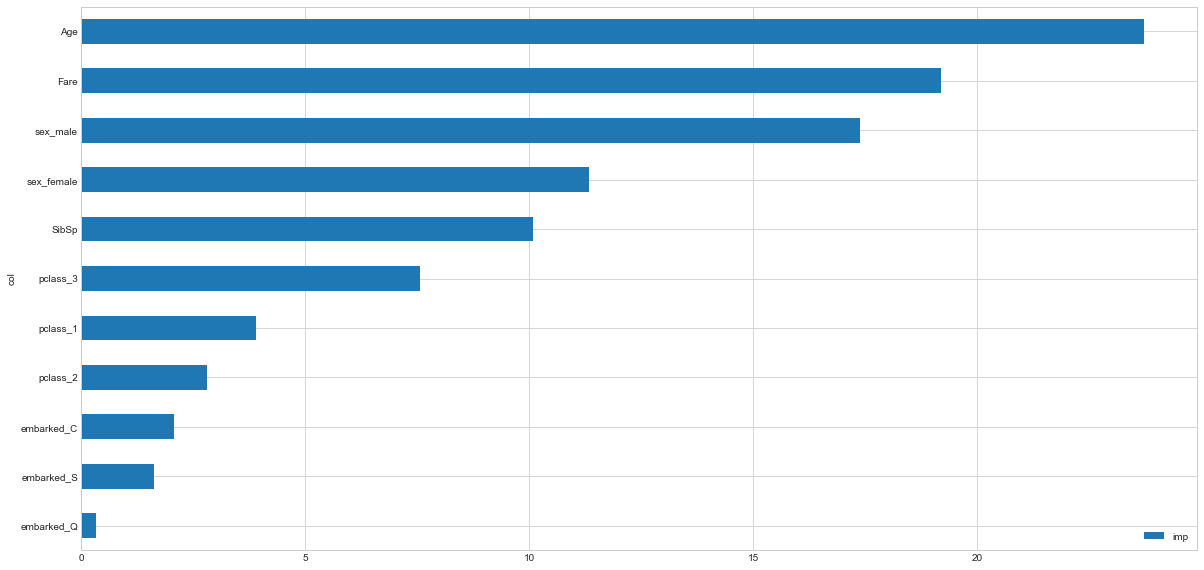

In [59]:
feature_importance(catboost_model, X_train)

In [60]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.9111881692336086
Recall: 0.77178125
F1: 0.8355640212364365
AUC: 0.9320310698375261


In [61]:
test_embarked_one_hot = pd.get_dummies(test['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test['Pclass'], 
                                   prefix='pclass')

In [62]:
test = pd.concat([test, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)

In [63]:
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Age', 'SibSp', 'Fare', 'embarked_C', 'embarked_Q', 'embarked_S',
       'sex_female', 'sex_male', 'pclass_1', 'pclass_2', 'pclass_3'],
      dtype='object')

In [64]:
predictions = catboost_model.predict(test[wanted_test_columns])

In [65]:
predictions[:20]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0.])

In [66]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0


In [67]:
submission['Survived'] = submission['Survived'].astype(int)

In [68]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [69]:
submission.to_csv("my_submission.csv", index=False)

In [70]:
submissions_check = pd.read_csv("my_submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [71]:
# DISCLAIMER: THIS CODE IS A RESULT OF FOLLOWING THIS TUTORIAL: https://www.youtube.com/watch?v=f1y9wDDxWnAx